In [1]:
import sys
import numpy as np
import pickle
import os
import re
import pandas as pd
import math
import matplotlib.pyplot as plt
from pathlib import Path
from pickle import dump, load
from math import log,log2
sys.path.append('/home/scarlett/github/Ipy_notebook')  
from Python.quickBeast import get_NS_p_values, get_data, get_qb_ns_data
BEASTIE_path="/home/scarlett/github/BEASTIE"
sys.path.append(str(BEASTIE_path))
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from prettytable import PrettyTable
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## 1. read p-values from each method, multiple testing corrections <br>2. assess whether p-values accurate at the tail (empirical p-values vs t-pval) <br>3. plot them out

#### checking the p-values from qb output

In [2]:


# def qq_norm(data):
#     # Without fit=True: The sample quantiles are plotted against the theoretical quantiles of a standard normal distribution.
#     # With fit=True: The sample data's mean and standard deviation are used to standardize both the sample data and the theoretical quantiles of the standard normal distribution before plotting them against each other.
#     data_array = np.array(data)
#     sm.qqplot(data_array, line='45', fit=True)
#     plt.title('QQ plot against normal distribution')
#     plt.show()

# def qq_skewed_t(data):
#     # Convert data to numpy array
#     data_array = np.array(data)
#     # Fit data to a t-distribution to get the parameters
#     df, loc, scale = t.fit(data_array)
#     # Calculate the theoretical quantiles for the t-distribution
#     theoretical_quantiles = t.ppf(np.linspace(0, 1, len(data_array)), df, loc, scale)
    
#     # Sort data
#     sorted_data = np.sort(data_array)
#     # Get the min and max values across both datasets for the y=x line
#     min_val = min(min(sorted_data), min(theoretical_quantiles))
#     max_val = max(max(sorted_data), max(theoretical_quantiles))
#     # Plot
#     plt.plot(theoretical_quantiles,sorted_data, 'o')
#     plt.plot([min(sorted_data), max(sorted_data)],
#             [min(sorted_data), max(sorted_data)], 'r-')  # line of equality
#     plt.ylabel('Observed Data')
#     plt.xlabel('Theoretical Quantiles (t-distribution)')
#     plt.title('QQ plot against t-distribution')
#     plt.show()

def get_corrected_p(qb_POS_p,qb_NEG_p):
    # Apply FDR correction
    _, qb_POS_p_fdr, _, _ = multipletests(qb_POS_p, method='fdr_bh')
    _, qb_NEG_p_fdr, _, _ = multipletests(qb_NEG_p, method='fdr_bh')

    # Apply Bonferroni correction
    _, qb_POS_p_bonf, _, _ = multipletests(qb_POS_p, method='bonferroni')
    _, qb_NEG_p_bonf, _, _ = multipletests(qb_NEG_p, method='bonferroni')
    return qb_POS_p_fdr, qb_NEG_p_fdr, qb_POS_p_bonf, qb_NEG_p_bonf



### 1. get p-values from each methods

In [4]:
n_gene=1000
n_null=19207904
n_hets=10
n_depth=100
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,b_pos_p, b_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
qb_pos_p_fdr, qb_neg_p_fdr, qb_pos_p_bonf, qb_neg_p_bonf = get_corrected_p(qb_pos_p,qb_neg_p)
b_pos_p_fdr, b_neg_p_fdr, b_pos_p_bonf, b_neg_p_bonf = get_corrected_p(b_pos_p,b_neg_p)
ns_pos_p_fdr, ns_neg_p_fdr, ns_pos_p_bonf, ns_neg_p_bonf = get_corrected_p(ns_pos_p,ns_neg_p)

### 2. assess whether p-values accurate at the tail (empirical p-values vs t-pval)

In [5]:
NEG=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
POS=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
ns_NEG,ns_POS,qb_NEG_name,qb_POS_name = get_filename(POS,NEG)
path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
emp_qb_POS, emp_qb_NEG = get_qb_output(qb_POS_name, qb_NEG_name, path_qb)

In [6]:
emp_qb_NEG

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,normal_p_value,t_p_value,st_p_value
0,gene80001,0.050950,0.04545,-0.021141,0.009252,-0.219791,0.791817,0.800333,0.836007
1,gene80002,0.027420,0.04545,-0.026846,0.006036,-0.345532,0.665435,0.659294,0.697920
2,gene80003,0.151292,0.04545,0.038007,0.015482,0.305455,0.660096,0.591498,0.618735
3,gene80004,0.083560,0.04545,0.064259,0.007111,0.762037,0.293022,0.240846,0.293175
4,gene80005,0.152114,0.04545,0.093242,0.008209,1.029140,0.158721,0.132156,0.174914
...,...,...,...,...,...,...,...,...,...
19207899,gene19189996,0.195247,0.04545,0.072761,0.012598,0.648264,0.368609,0.306938,0.358918
19207900,gene19189997,0.024982,0.04545,-0.049154,0.004533,-0.730042,0.343336,0.322077,0.331342
19207901,gene19189998,0.108803,0.04545,0.094183,0.005383,1.283740,0.080032,0.072972,0.101269
19207902,gene19189999,0.010073,0.04545,-0.029116,0.004183,-0.450181,0.566894,0.551950,0.587425


In [3]:
def calculate_empirical_pvalues(df, null_dataframe):
    # Sort the null dataframe's zscore values
    null_dataframe = null_dataframe.sort_values(by='qb_zscore')

    # Initialize an empty list to store the p-values
    pvalues = []

    # Loop through the zscore values in your original dataframe
    for zscore in df['qb_zscore']:
        # Calculate the two-sided p-value based on the null distribution
        left_tail_p = (null_dataframe['qb_zscore'] <= zscore).mean()
        right_tail_p = (null_dataframe['qb_zscore'] >= zscore).mean()
        two_sided_pvalue = 2 * min(left_tail_p, right_tail_p)

        # Append the p-value to the list
        pvalues.append(two_sided_pvalue)

    # Add the calculated p-values as a new column in your original dataframe
    df['empirical_pval'] = pvalues

    return df

In [7]:
power_emp = calculate_empirical_pvalues(qb_POS, emp_qb_NEG)
type1_emp = calculate_empirical_pvalues(qb_NEG, emp_qb_NEG)

In [7]:
type1_emp

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,normal_p_value,t_p_value,st_p_value,empirical_pval
0,gene1,0.101201,0.04545,0.086962,0.005999,1.122750,0.102266,0.102173,0.101116,0.109484
1,gene2,0.251615,0.04545,0.128099,0.006541,1.583840,0.020482,0.020763,0.019774,0.035245
2,gene3,0.178368,0.04545,0.103120,0.006770,1.253260,0.067638,0.067733,0.066524,0.079550
3,gene4,0.084335,0.04545,0.057243,0.008745,0.612111,0.380442,0.379484,0.380656,0.356248
4,gene5,0.008797,0.04545,-0.019962,0.004308,-0.304116,0.630535,0.629609,0.628620,0.640599
...,...,...,...,...,...,...,...,...,...,...
995,gene996,0.010031,0.04545,0.024844,0.004349,0.376746,0.597348,0.596458,0.598781,0.564216
996,gene997,0.104312,0.04545,0.059566,0.009155,0.622547,0.372098,0.371147,0.372261,0.348469
997,gene998,0.020737,0.04545,-0.025749,0.005150,-0.358804,0.574093,0.573092,0.572422,0.582627
998,gene999,0.012023,0.04545,-0.023482,0.004786,-0.339416,0.593828,0.592851,0.592068,0.602863


In [8]:
power_emp

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,normal_p_value,t_p_value,st_p_value,empirical_pval
0,gene1,1.000000,0.04545,-0.686825,0.004422,-10.32810,1.654860e-50,1.654634e-50,3.956707e-63,0.0
1,gene2,1.000000,0.04545,-0.625589,0.004337,-9.49918,5.739254e-43,5.738589e-43,2.173290e-53,0.0
2,gene3,1.000000,0.04545,-0.578265,0.004278,-8.84140,1.977120e-37,1.976922e-37,2.916409e-46,0.0
3,gene4,1.000000,0.04545,-0.582540,0.004283,-8.90134,6.423925e-38,6.423271e-38,6.876158e-47,0.0
4,gene5,0.999985,0.04545,-0.447899,0.004146,-6.95630,9.569536e-24,9.568939e-24,8.959939e-29,0.0
...,...,...,...,...,...,...,...,...,...,...
995,gene996,1.000000,0.04545,-0.647323,0.004366,-9.79614,1.348094e-45,1.347927e-45,8.810694e-57,0.0
996,gene997,1.000000,0.04545,-0.686825,0.004423,-10.32790,1.662096e-50,1.661869e-50,3.979110e-63,0.0
997,gene998,1.000000,0.04545,-0.776541,0.004563,-11.49530,3.449144e-62,3.448561e-62,2.809332e-78,0.0
998,gene999,1.000000,0.04545,-0.749326,0.004519,-11.14730,1.414615e-58,1.414390e-58,1.382912e-73,0.0


### 3.plot p-values along with empirical p-values

In [8]:
df = type1_emp
empirical_p = df['empirical_pval'].tolist()
fitted_st_p = df['st_p_value'].tolist()
fitted_t_p = df['t_p_value'].tolist()
fitted_n_p = df['normal_p_value'].tolist()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_p_value_comparisons_2x2(fitted_p_values, empirical_p_values, fitted_distribution):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Histogram Comparison
    axs[0, 0].hist(fitted_p_values, bins=50, alpha=0.5, label=f'Fitted {fitted_distribution} P-values')
    axs[0, 0].hist(empirical_p_values, bins=50, alpha=0.5, label='Empirical P-values')
    axs[0, 0].set_title('Histogram Comparison of P-values')
    axs[0, 0].set_xlabel('P-value')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()

    # Q-Q Plot
    (osm, osr), (slope, intercept, r) = stats.probplot(fitted_p_values, dist="uniform", fit=True)
    axs[0, 1].plot(osm, osr, 'o', label=f'Fitted {fitted_distribution} P-values')
    (osm, osr), (slope, intercept, r) = stats.probplot(empirical_p_values, dist="uniform", fit=True)
    axs[0, 1].plot(osm, slope*osm + intercept, 'r-', label='Fit Line')
    axs[0, 1].set_title(f'Q-Q Plot Comparing Fitted {fitted_distribution} and Empirical P-values')
    axs[0, 1].set_xlabel('Theoretical Quantiles')
    axs[0, 1].set_ylabel('Sample Quantiles')
    axs[0, 1].legend()

    # CDF Plot
    axs[1, 0].hist(fitted_p_values, bins=100, density=True, histtype='step', cumulative=True, label=f'Fitted {fitted_distribution} P-values')
    axs[1, 0].hist(empirical_p_values, bins=100, density=True, histtype='step', cumulative=True, label='Empirical P-values')
    axs[1, 0].set_title('Cumulative Distribution Function (CDF) of P-values')
    axs[1, 0].set_xlabel('P-value')
    axs[1, 0].set_ylabel('CDF')
    axs[1, 0].legend()

    # Scatter Plot
    axs[1, 1].scatter(fitted_p_values, empirical_p_values, alpha=0.5)
    axs[1, 1].set_title(f'Scatter Plot of Fitted {fitted_distribution} vs. Empirical P-values')
    axs[1, 1].set_xlabel(f'Fitted {fitted_distribution} P-values')
    axs[1, 1].set_ylabel('Empirical P-values')
    axs[1, 1].plot([0, 1], [0, 1], 'r--')  # Line y=x for reference

    plt.tight_layout()
    plt.show()

# Example usage
# plot_p_value_comparisons_2x2(fitted_p_values, empirical_p_values, 'Normal')



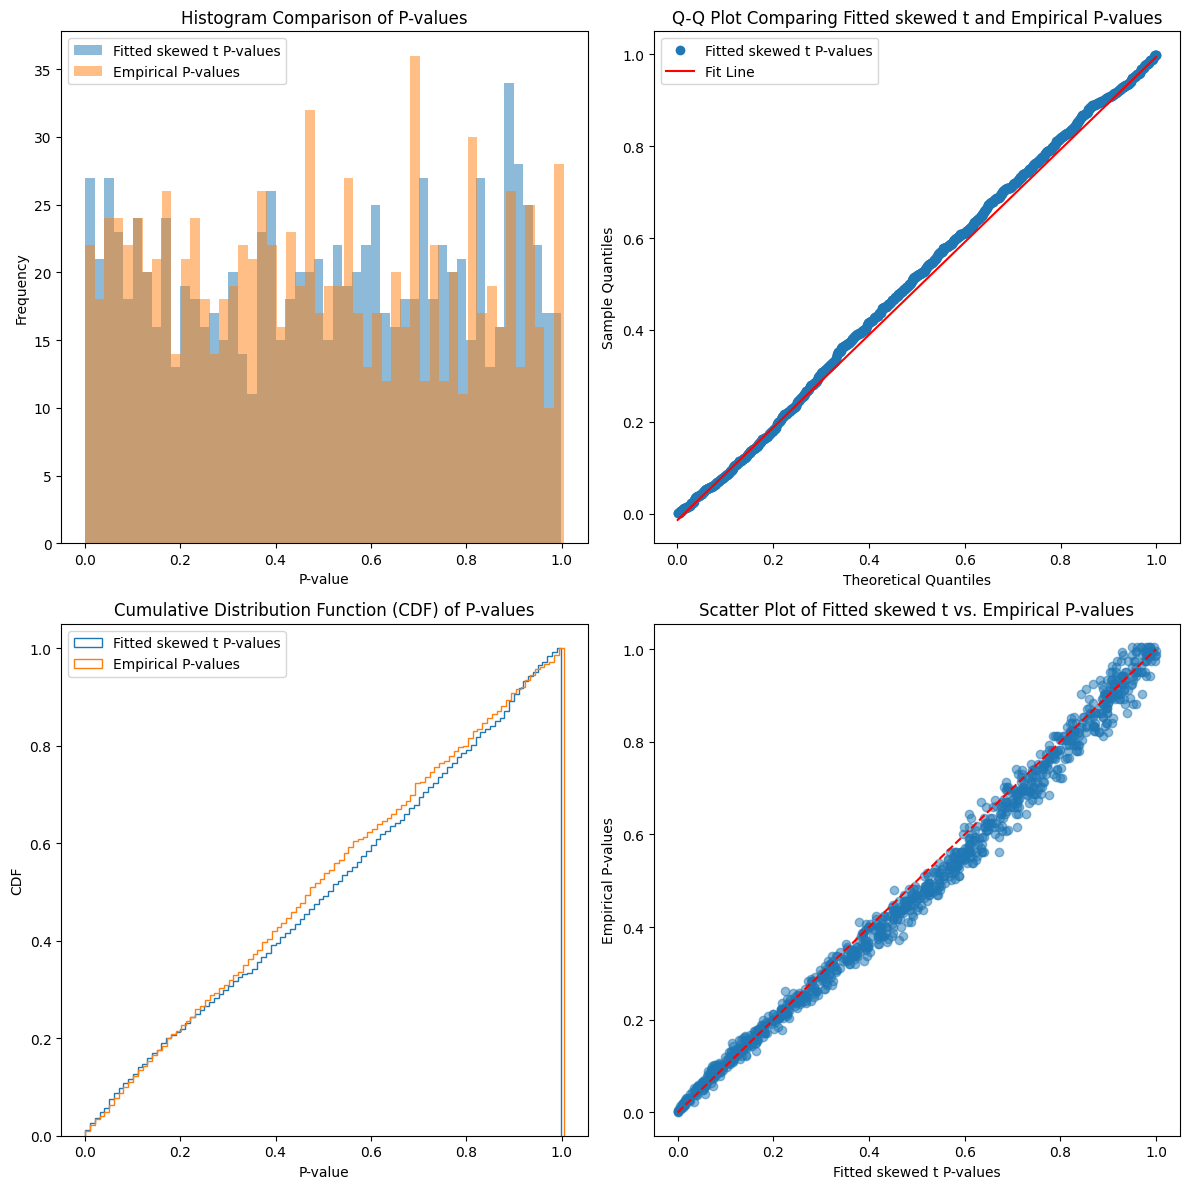

In [10]:
# Plot the comparisons
plot_p_value_comparisons_2x2(fitted_st_p, empirical_p,"skewed t")

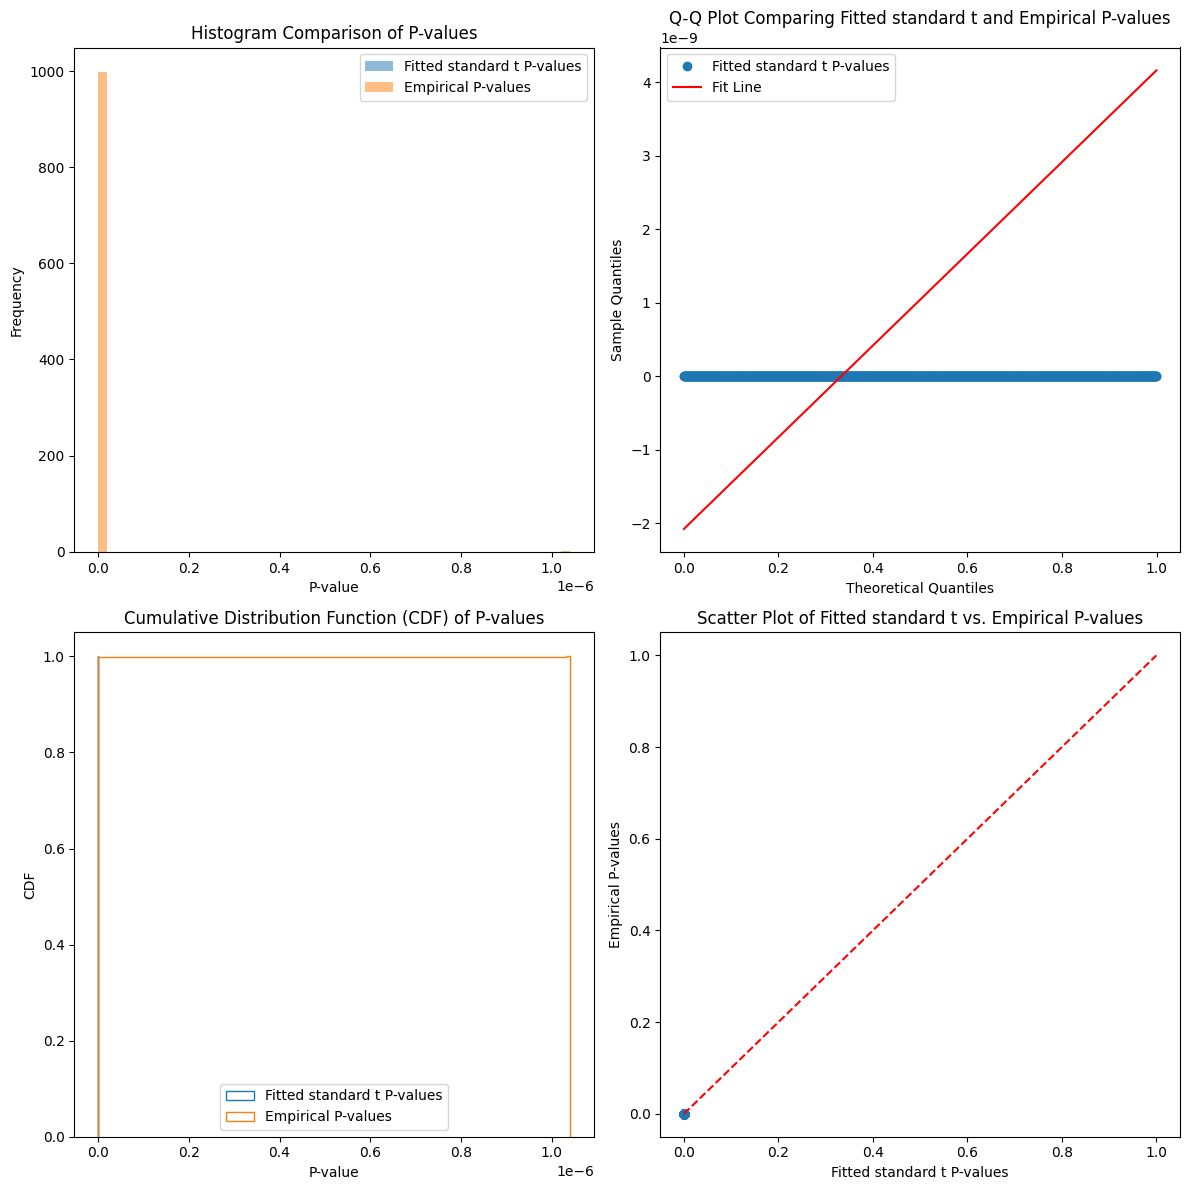

In [25]:
# Plot the comparisons
plot_p_value_comparisons_2x2(fitted_t_p, empirical_p,"standard t")

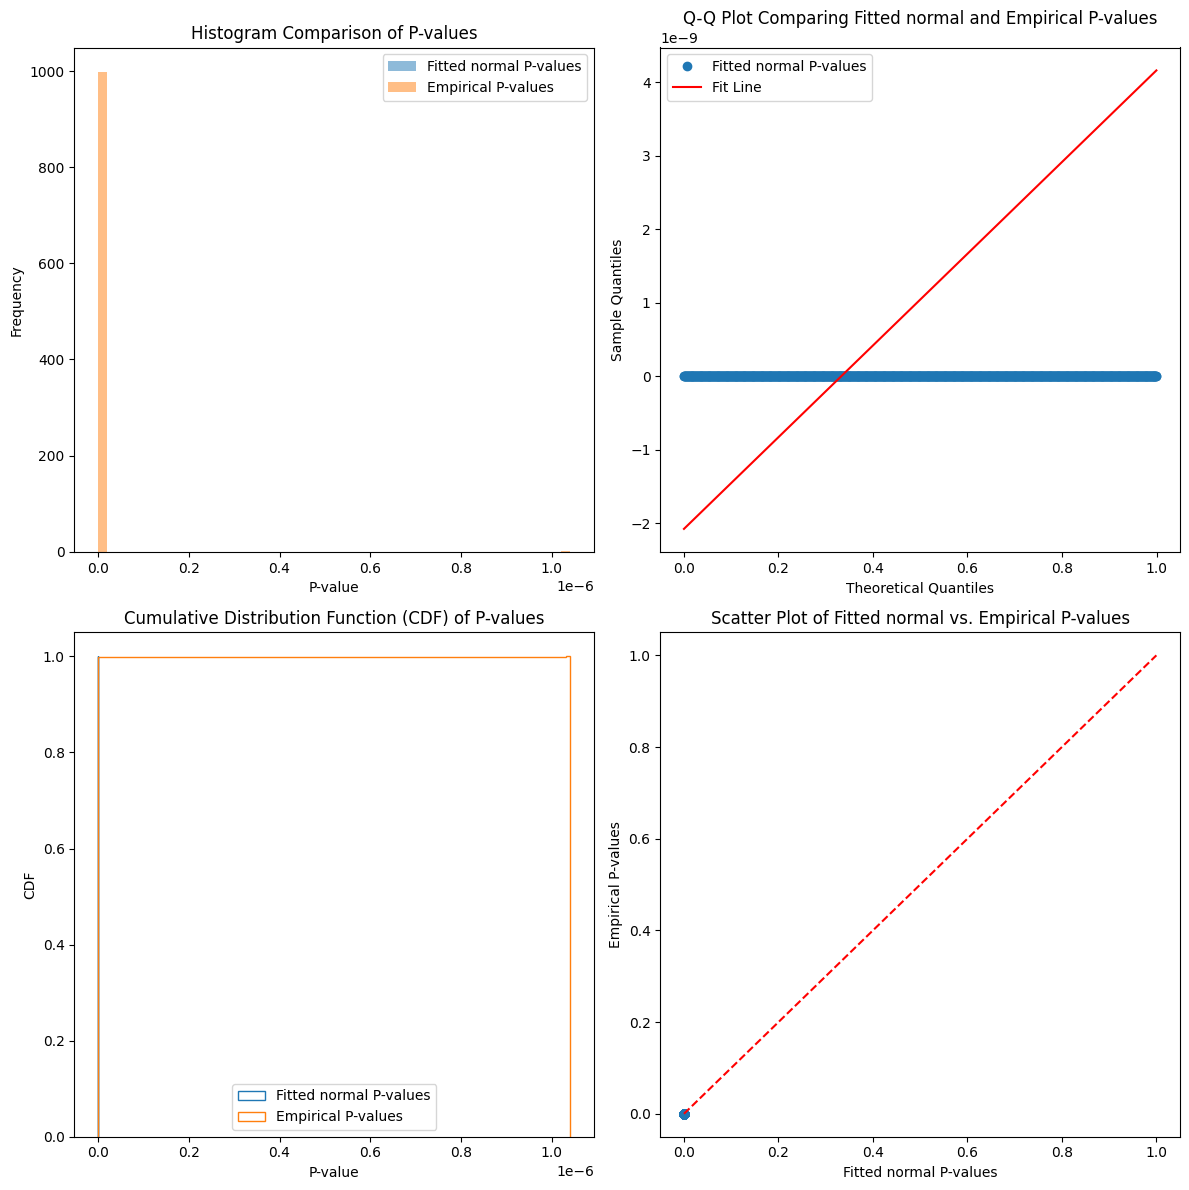

In [26]:
# Plot the comparisons
plot_p_value_comparisons_2x2(fitted_n_p, empirical_p,"normal")

(array([110.,  90., 105., 110.,  98.,  97.,  85.,  90., 109., 106.]),
 array([6.12560329e-04, 1.00528043e-01, 2.00443526e-01, 3.00359008e-01,
        4.00274491e-01, 5.00189974e-01, 6.00105457e-01, 7.00020939e-01,
        7.99936422e-01, 8.99851905e-01, 9.99767387e-01]),
 <BarContainer object of 10 artists>)

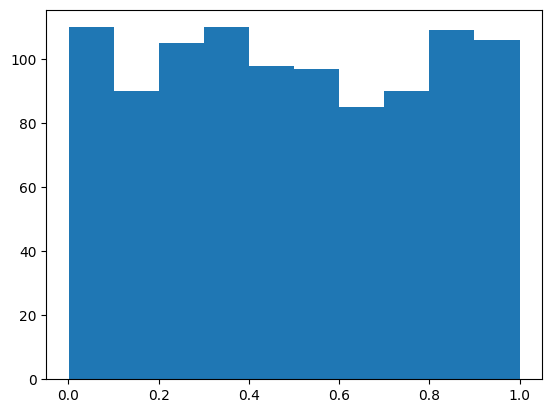

In [12]:
plt.hist(type1_emp["empirical_pval"].values)

In [11]:
import numpy as np
import matplotlib.pyplot as plt4

def plot_empirical_CDF(df,pval_column,dist):
    # Sample p-values from fitted t-distribution (replace this with your actual data)
    fitted_p_values = df[pval_column].values
    # Sample empirical p-values from null simulations (replace this with your actual data)
    empirical_p_values = df["empirical_pval"].values
    # Calculate -log10 of the p-values
    log10_fitted_p_values = -np.log10(fitted_p_values)
    log10_empirical_p_values = -np.log10(empirical_p_values)
    # Compute the empirical CDF
    ecdf = sm.distributions.ECDF(log10_empirical_p_values)
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    # Plot the fitted vs. empirical p-values
    ax1.scatter(log10_fitted_p_values, log10_empirical_p_values, s=5, alpha=0.5, label=f'Fitted {dist} vs. Empirical P-Values')
    ax1.plot([0, 9], [0, 9], linestyle='--', color='red', label='y=x')
    ax1.set_xlabel(f'-log10(Fitted {dist} P-Values)', fontsize=12)
    ax1.set_ylabel('-log10(Empirical P-Values)', fontsize=12)
    ax1.set_title(f'Fitted {dist} vs. Empirical P-Values Plot', fontsize=14)
    ax1.legend()
    ax1.grid(True)
    # Plot the empirical CDF
    x = np.linspace(min(log10_empirical_p_values), max(log10_empirical_p_values), 1000)
    y = ecdf(x)
    ax2.plot(x, y, label='Empirical CDF')
    ax2.plot([0, 5], [0, 5], linestyle='--', color='red', label='y=x')
    ax2.set_xlabel('-log10(Empirical P-Values)', fontsize=12)
    ax2.set_ylabel('Empirical CDF', fontsize=12)
    ax2.set_title('Empirical CDF Plot', fontsize=14)
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()


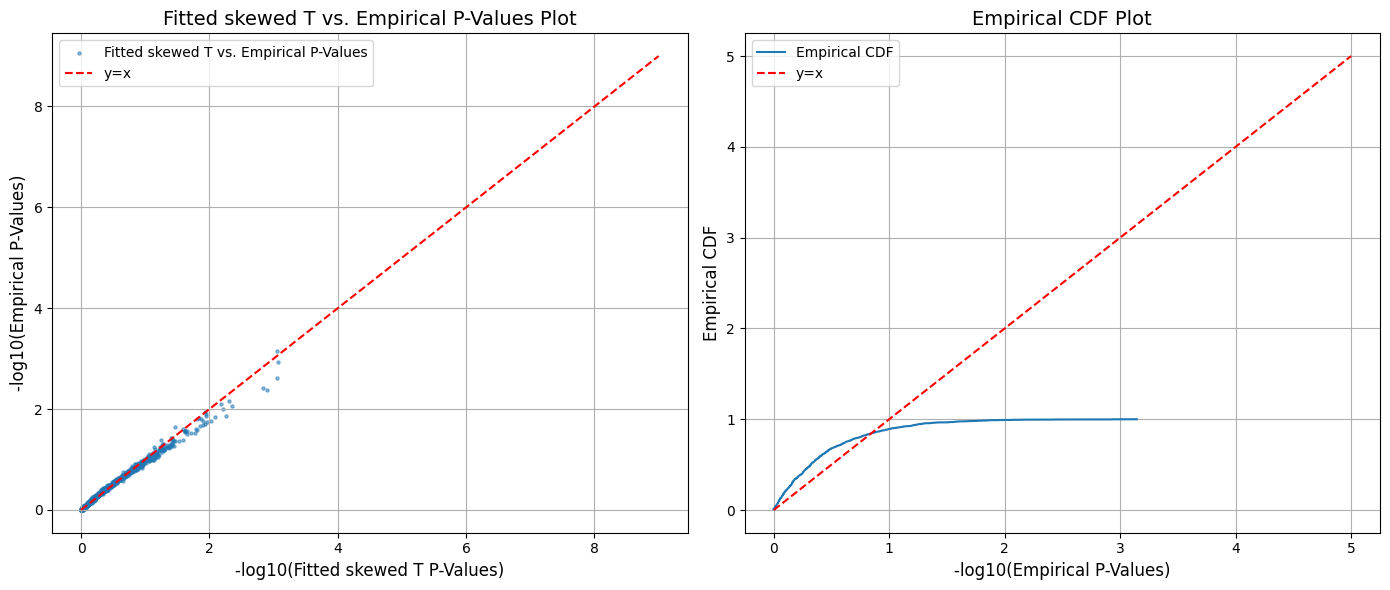

In [12]:
plot_empirical_CDF(type1_emp,"st_p_value","skewed T")

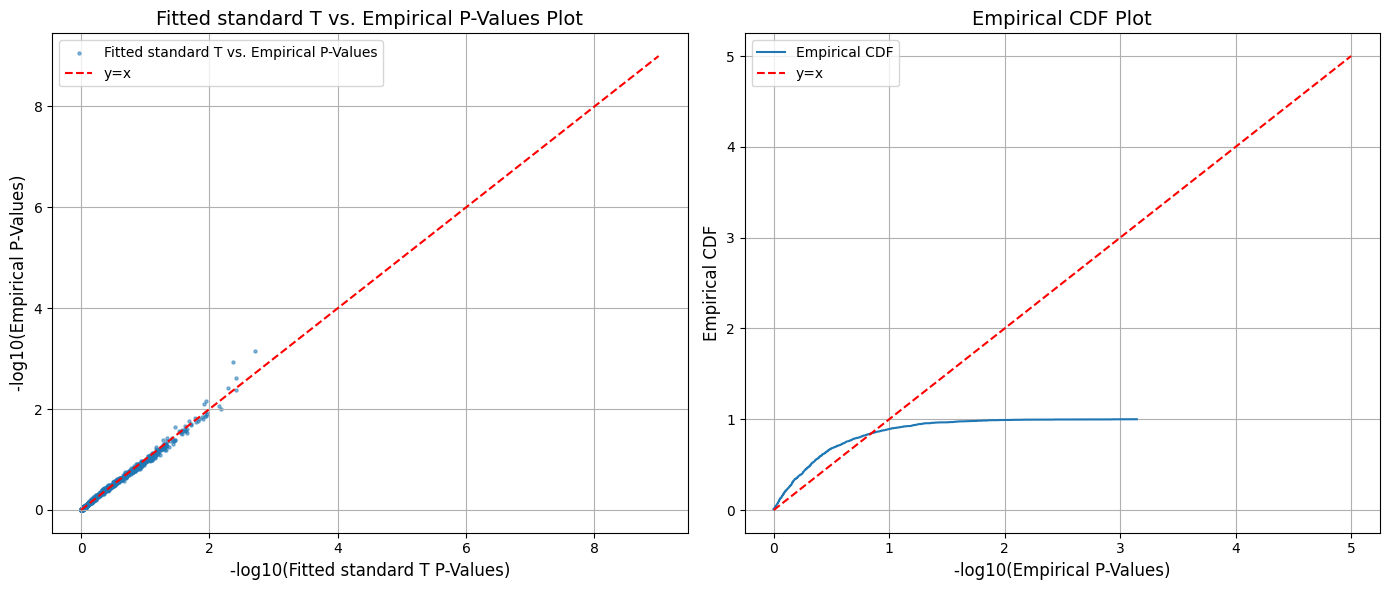

In [13]:
plot_empirical_CDF(type1_emp,"t_p_value","standard T")

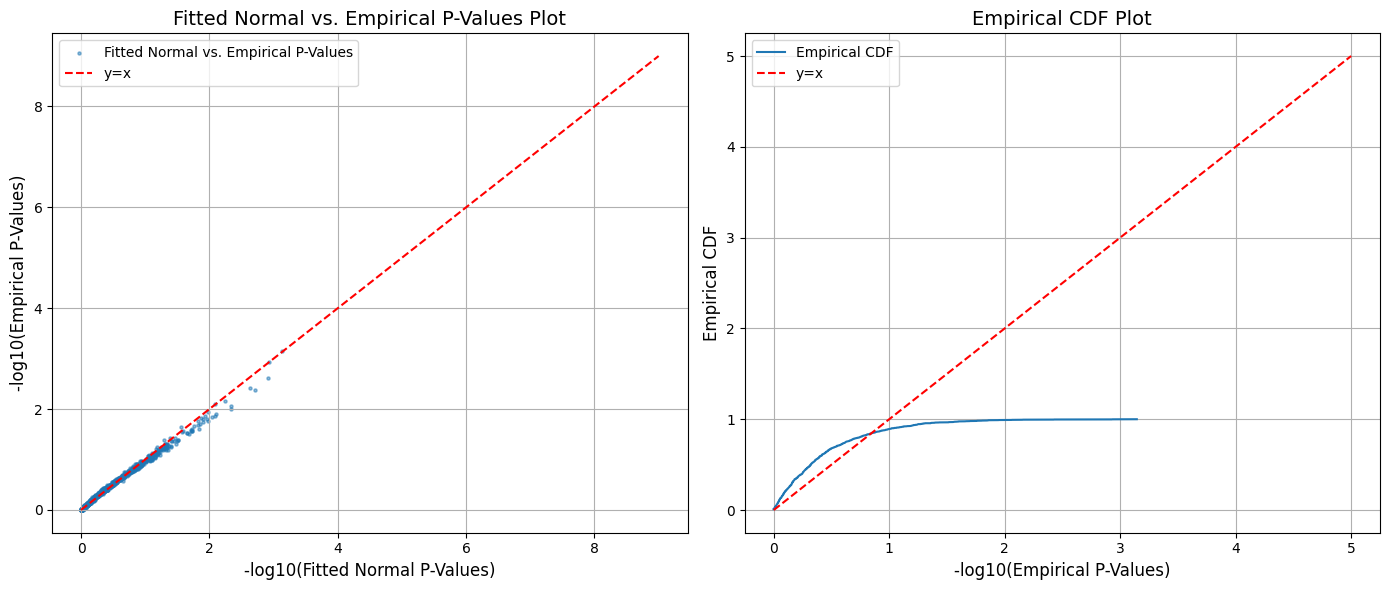

In [14]:
plot_empirical_CDF(type1_emp,"normal_p_value","Normal")

/tmp/ipykernel_1975489/584999179.py:13: RuntimeWarning: divide by zero encountered in log10
  log10_empirical_p_values = -np.log10(empirical_p_values)


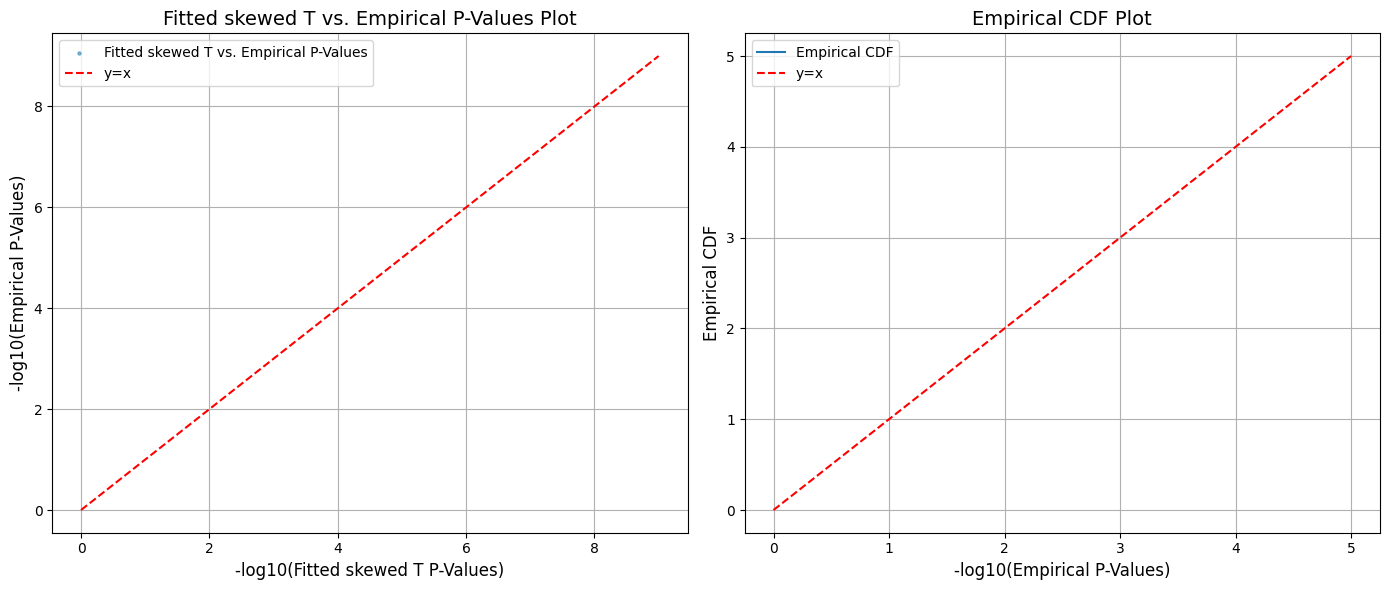

In [15]:
plot_empirical_CDF(power_emp,"st_p_value","skewed T")

/tmp/ipykernel_1975489/584999179.py:13: RuntimeWarning: divide by zero encountered in log10
  log10_empirical_p_values = -np.log10(empirical_p_values)


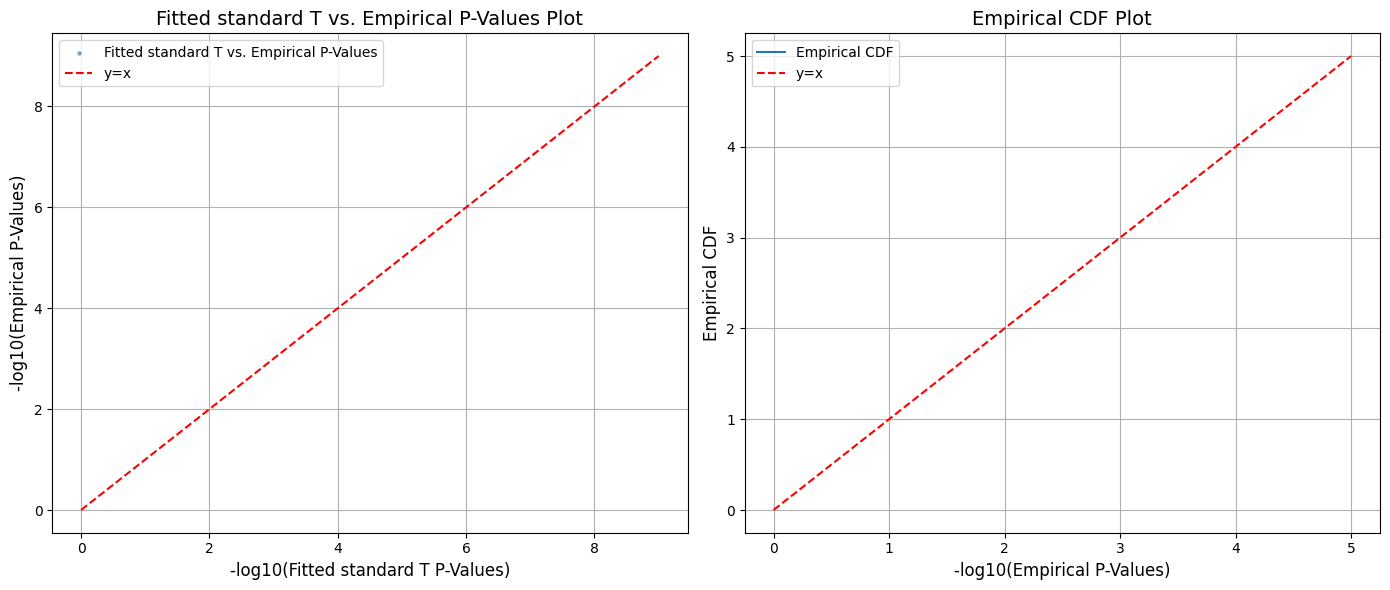

In [16]:
plot_empirical_CDF(power_emp,"t_p_value","standard T")

/tmp/ipykernel_1975489/584999179.py:13: RuntimeWarning: divide by zero encountered in log10
  log10_empirical_p_values = -np.log10(empirical_p_values)


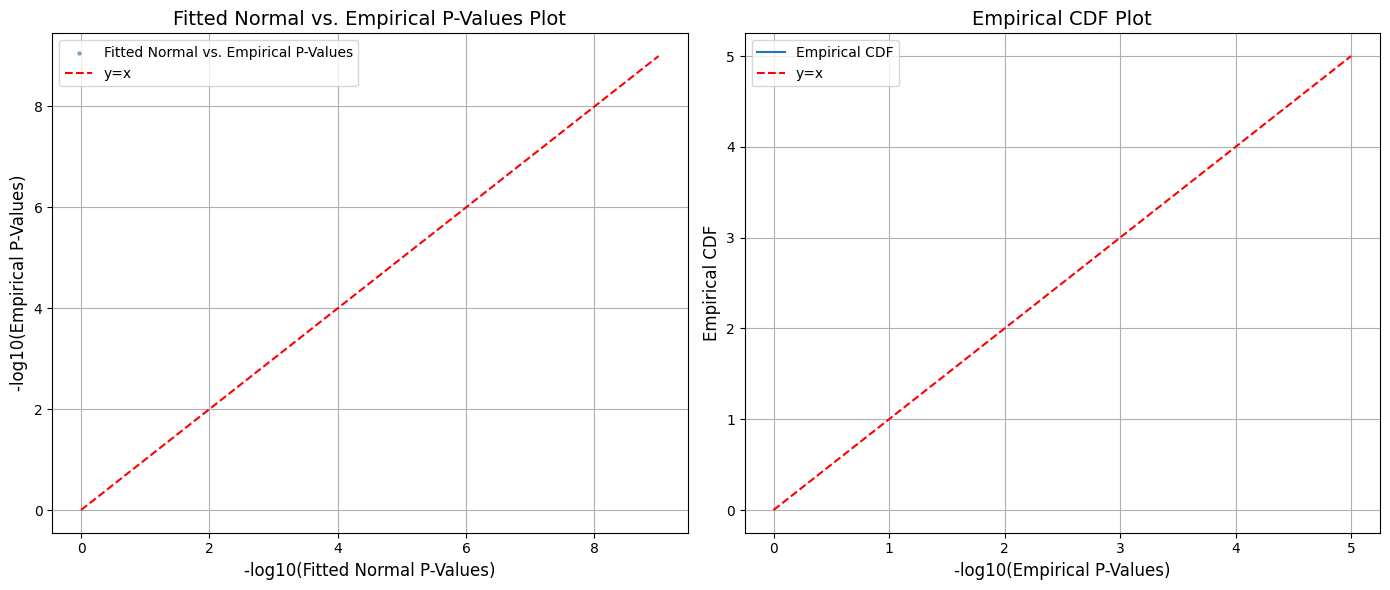

In [17]:
plot_empirical_CDF(power_emp,"normal_p_value","Normal")

In [18]:
n_gene=1000
n_null=19207904
n_hets=3
n_depth=30
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,b_pos_p, b_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
qb_pos_p_fdr, qb_neg_p_fdr, qb_pos_p_bonf, qb_neg_p_bonf = get_corrected_p(qb_pos_p,qb_neg_p)
b_pos_p_fdr, b_neg_p_fdr, b_pos_p_bonf, b_neg_p_bonf = get_corrected_p(b_pos_p,b_neg_p)
ns_pos_p_fdr, ns_neg_p_fdr, ns_pos_p_bonf, ns_neg_p_bonf = get_corrected_p(ns_pos_p,ns_neg_p)
#
NEG=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
POS=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
ns_NEG,ns_POS,qb_NEG_name,qb_POS_name = get_filename(POS,NEG)
path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
emp_qb_POS, emp_qb_NEG = get_qb_output(qb_POS_name, qb_NEG_name, path_qb)
#
power_emp = calculate_empirical_pvalues(qb_POS, emp_qb_NEG)
type1_emp = calculate_empirical_pvalues(qb_NEG, emp_qb_NEG)

In [19]:
type1_emp

,geneID,qb_mean,qb_var,qb_mode,qb_zscore,normal_p_value,t_p_value,st_p_value,empirical_pval
0,gene1,0.524373,0.002474,0.526103,0.526103,0.556961,0.555156,0.565615,0.563466
1,gene2,0.557164,0.003168,0.565707,0.565707,0.172473,0.170956,0.170504,0.147731
2,gene3,0.541202,0.002718,0.545905,0.545905,0.320834,0.316517,0.319284,0.309690
3,gene4,0.509549,0.002763,0.506101,0.506101,0.882797,0.882981,0.901279,0.900504
4,gene5,0.472114,0.002320,0.471497,0.471497,0.551549,0.537581,0.554064,0.510289
...,...,...,...,...,...,...,...,...,...
995,gene996,0.534933,0.002435,0.536604,0.536604,0.462537,0.443932,0.464688,0.403850
996,gene997,0.571118,0.002576,0.575007,0.575007,0.116416,0.113800,0.112570,0.115339
997,gene998,0.510597,0.002786,0.515202,0.515202,0.764411,0.758183,0.758727,0.747879
998,gene999,0.485336,0.002512,0.483598,0.483598,0.697865,0.678045,0.688264,0.716301


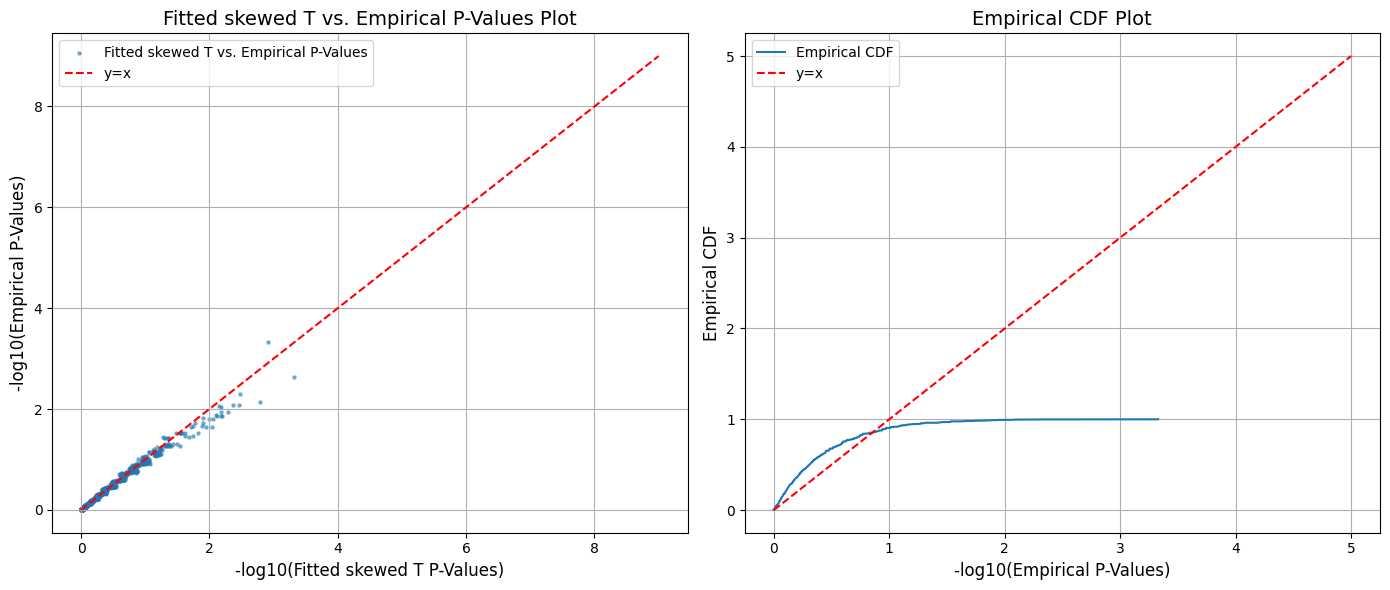

In [20]:
plot_empirical_CDF(type1_emp,"st_p_value","skewed T")

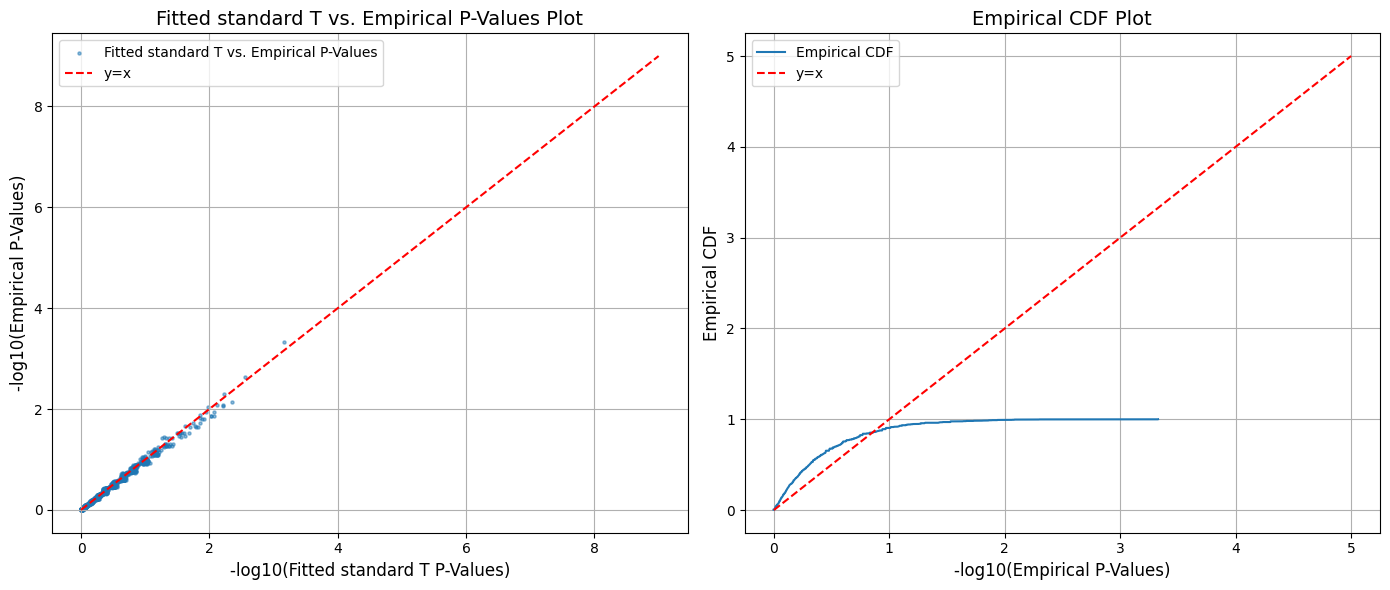

In [21]:
plot_empirical_CDF(type1_emp,"t_p_value","standard T")

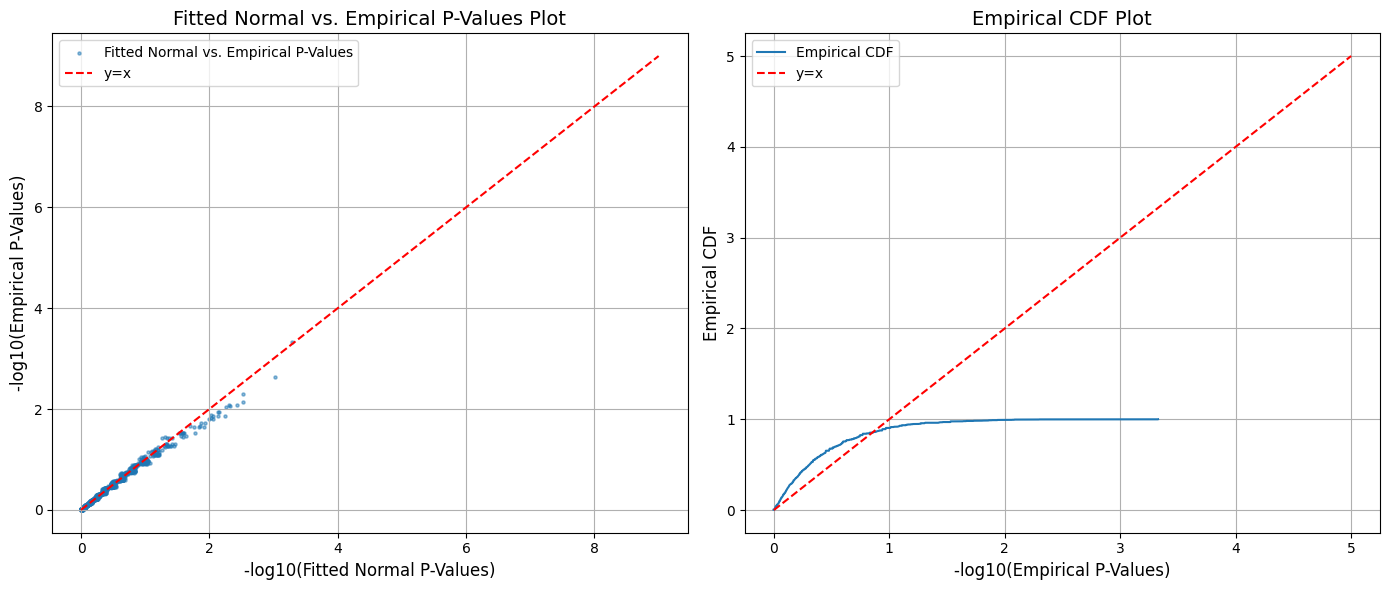

In [22]:
plot_empirical_CDF(type1_emp,"normal_p_value","Normal")

In [23]:
n_gene=1000
n_null=19207904
n_hets=1
n_depth=5
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,b_pos_p, b_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
qb_pos_p_fdr, qb_neg_p_fdr, qb_pos_p_bonf, qb_neg_p_bonf = get_corrected_p(qb_pos_p,qb_neg_p)
b_pos_p_fdr, b_neg_p_fdr, b_pos_p_bonf, b_neg_p_bonf = get_corrected_p(b_pos_p,b_neg_p)
ns_pos_p_fdr, ns_neg_p_fdr, ns_pos_p_bonf, ns_neg_p_bonf = get_corrected_p(ns_pos_p,ns_neg_p)
#
NEG=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
POS=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
ns_NEG,ns_POS,qb_NEG_name,qb_POS_name = get_filename(POS,NEG)
path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
emp_qb_POS, emp_qb_NEG = get_qb_output(qb_POS_name, qb_NEG_name, path_qb)
#
power_emp = calculate_empirical_pvalues(qb_POS, emp_qb_NEG)
type1_emp = calculate_empirical_pvalues(qb_NEG, emp_qb_NEG)

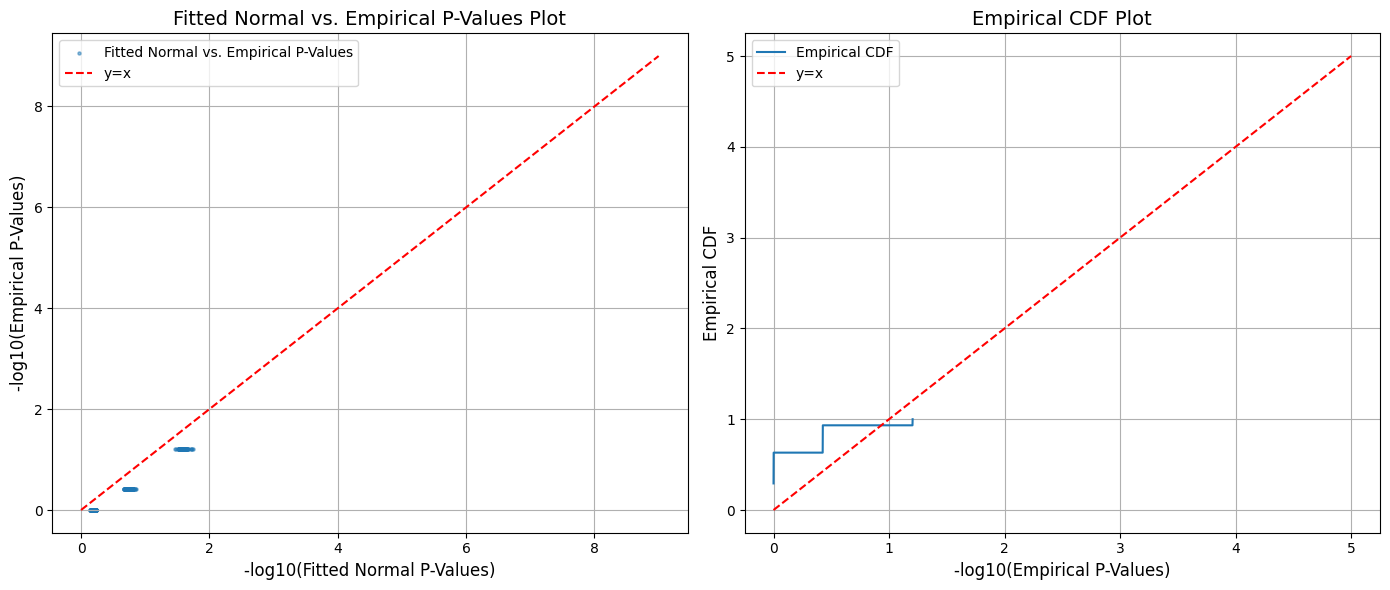

In [24]:
plot_empirical_CDF(type1_emp,"normal_p_value","Normal")

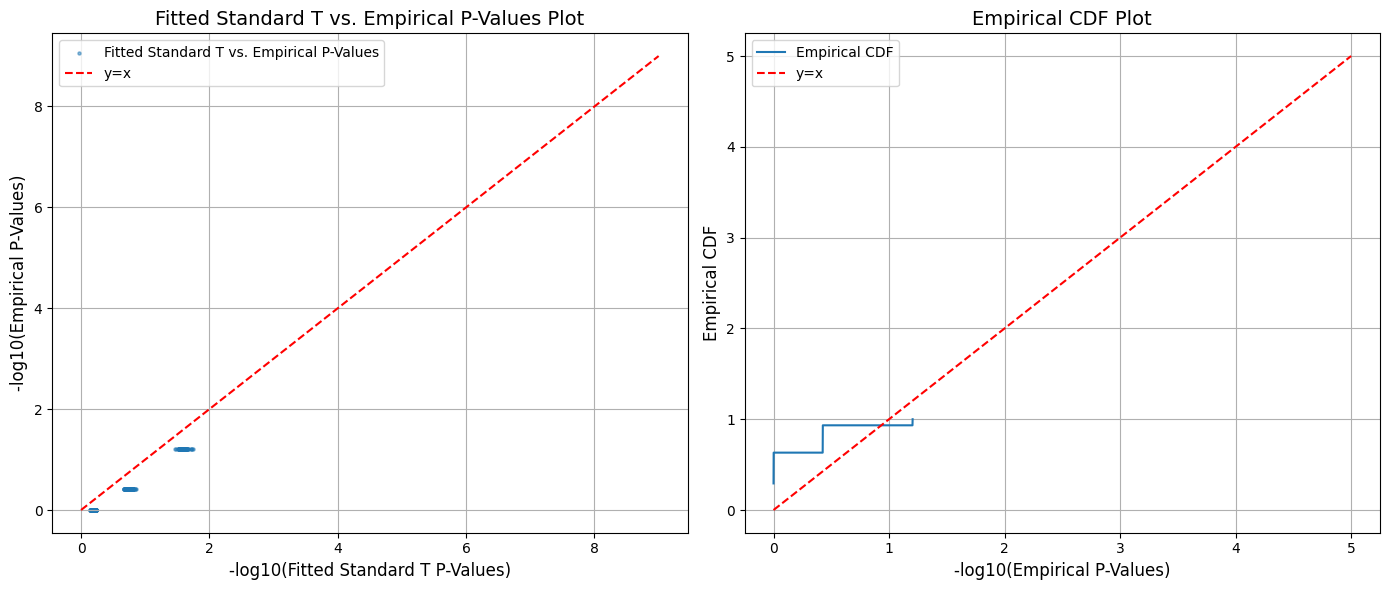

In [25]:
plot_empirical_CDF(type1_emp,"t_p_value","Standard T")

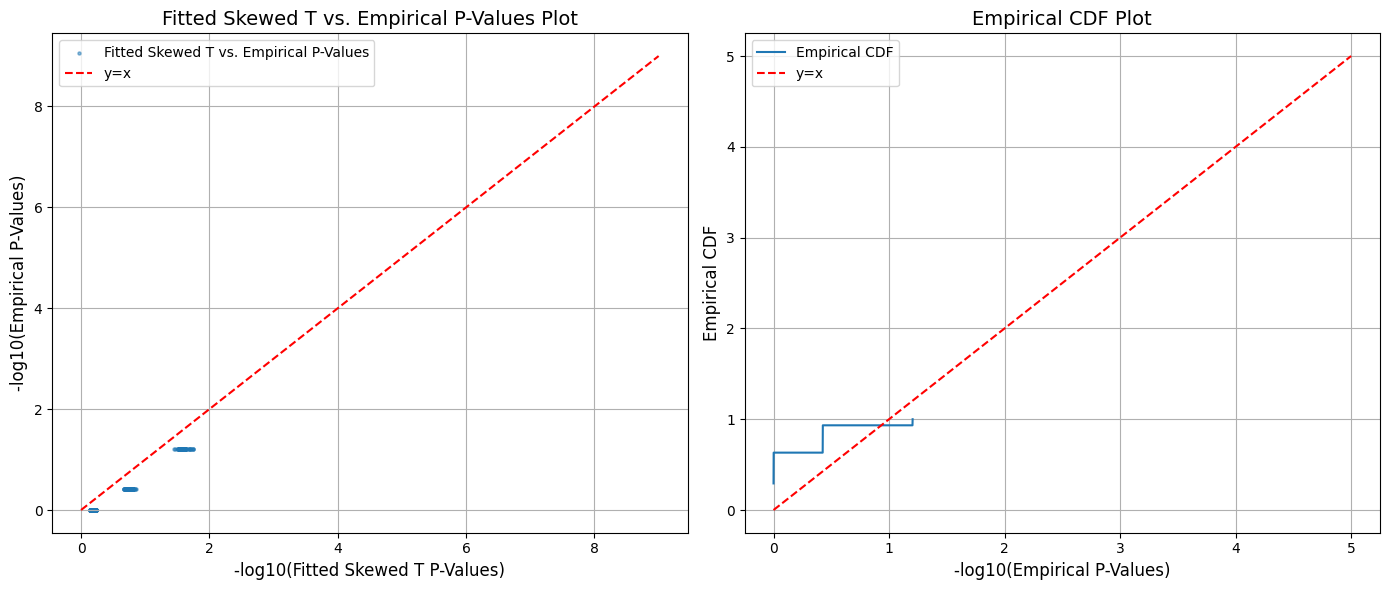

In [26]:
plot_empirical_CDF(type1_emp,"st_p_value","Skewed T")

In [27]:
n_gene=1000
n_null=19207904
n_hets=10
n_depth=100
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,b_pos_p, b_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
qb_pos_p_fdr, qb_neg_p_fdr, qb_pos_p_bonf, qb_neg_p_bonf = get_corrected_p(qb_pos_p,qb_neg_p)
b_pos_p_fdr, b_neg_p_fdr, b_pos_p_bonf, b_neg_p_bonf = get_corrected_p(b_pos_p,b_neg_p)
ns_pos_p_fdr, ns_neg_p_fdr, ns_pos_p_bonf, ns_neg_p_bonf = get_corrected_p(ns_pos_p,ns_neg_p)
#
NEG=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
POS=f"g-{n_null}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
ns_NEG,ns_POS,qb_NEG_name,qb_POS_name = get_filename(POS,NEG)
path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
emp_qb_POS, emp_qb_NEG = get_qb_output(qb_POS_name, qb_NEG_name, path_qb)
#
power_emp = calculate_empirical_pvalues(qb_POS, emp_qb_NEG)
type1_emp = calculate_empirical_pvalues(qb_NEG, emp_qb_NEG)

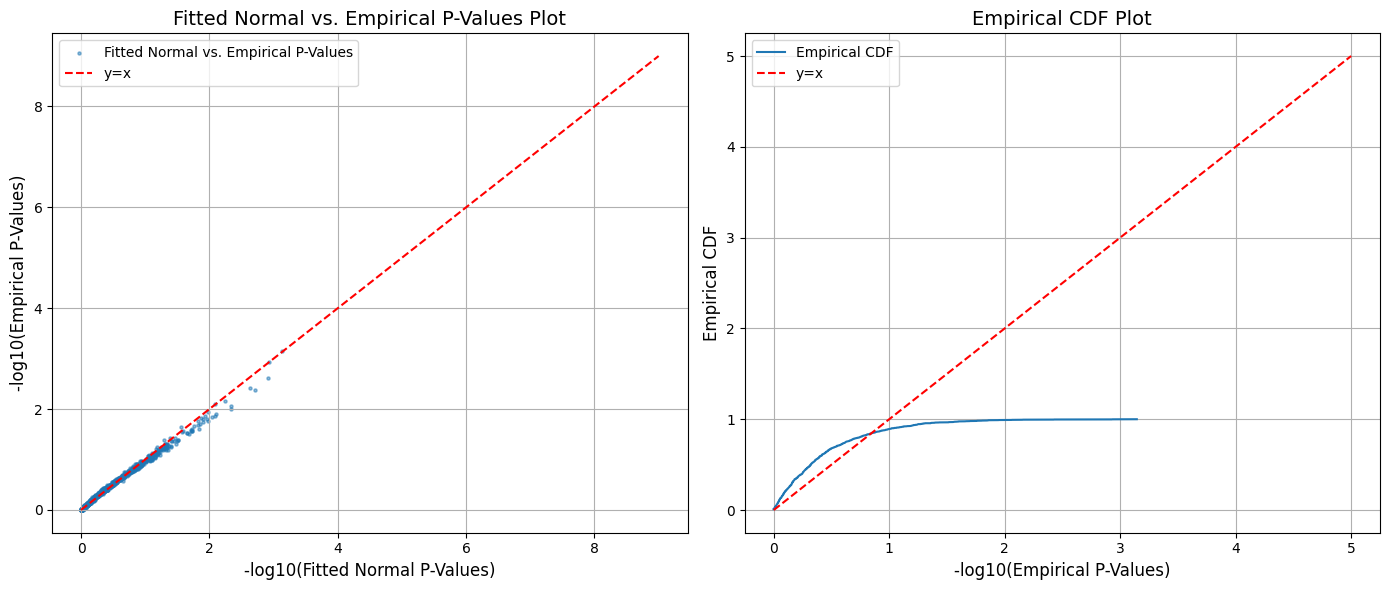

In [28]:
plot_empirical_CDF(type1_emp,"normal_p_value","Normal")

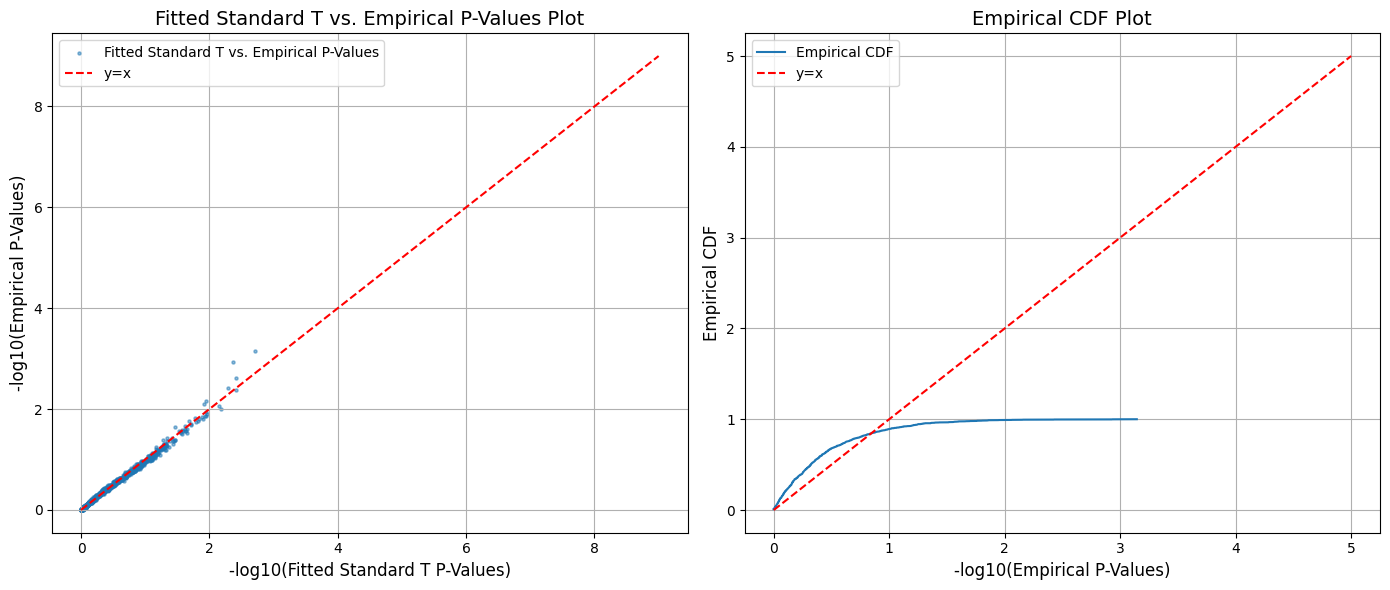

In [29]:
plot_empirical_CDF(type1_emp,"t_p_value","Standard T")

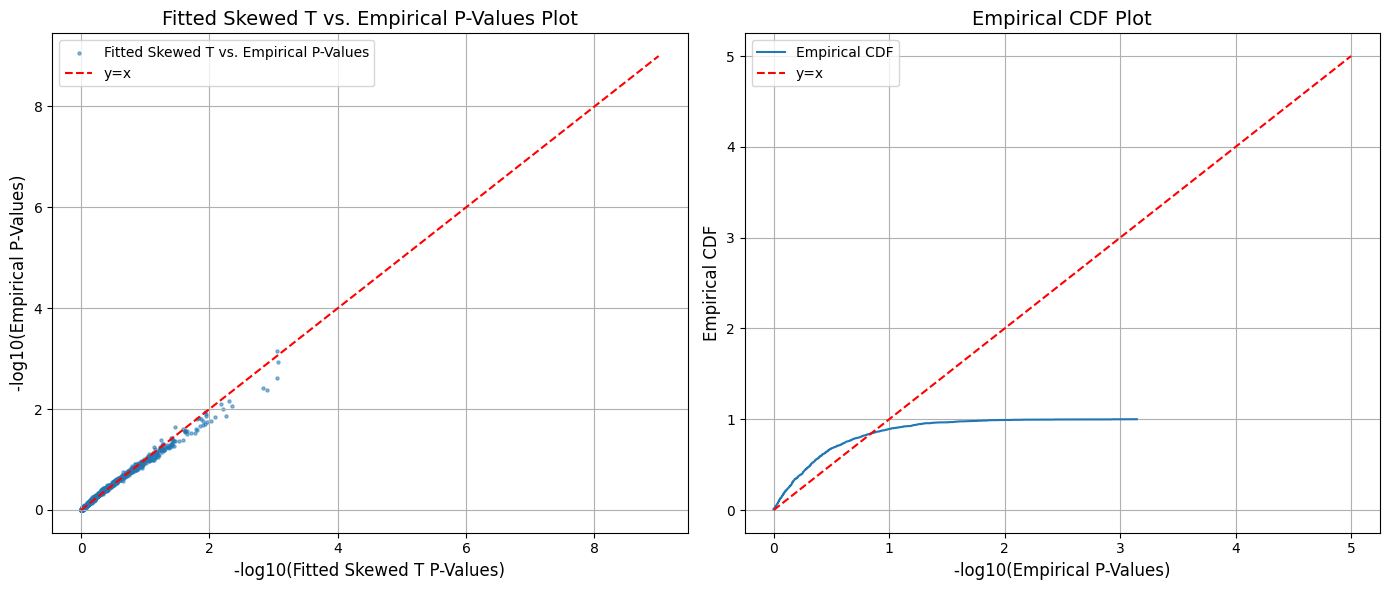

In [30]:
plot_empirical_CDF(type1_emp,"st_p_value","Skewed T")

In [10]:

def plot_empirical_CDF(fitted_p_values,dist="skewed T"):
    # Compute the empirical CDF
    ecdf_original = sm.distributions.ECDF(fitted_p_values)
    x = np.sort(fitted_p_values)
    y = ecdf_original(x)

    # Calculate -log10 of the p-values
    log10_fitted_p_values = -np.log10(fitted_p_values)
    #ecdf = sm.distributions.ECDF(log10_fitted_p_values)
    #x2 = np.sort(log10_fitted_p_values)
    #y2 = ecdf(x2)
    x2 = -np.log10(x)
    y2 = -np.log10(y)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    # Plot the fitted vs. empirical p-values
    ax1.scatter(x, y, s=5, alpha=0.5, label=f'Fitted {dist} P-Values')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='red', label='y=x')
    ax1.set_xlabel(f'Fitted {dist} P-Values', fontsize=12)
    ax1.set_title(f'Empirical CDF Plot', fontsize=14)
    ax1.legend()
    ax1.grid(True)
    # Plot the empirical CDF
    ax2.plot(x2, y2, label=f'-log10(Fitted {dist} P-Values)')
    ax2.plot([0, max(y2)], [0, max(y2)], linestyle='--', color='red', label='y=x')
    ax2.set_xlabel(f'-log10(fitted {dist} P-Values)', fontsize=12)
    ax2.set_title('Empirical CDF Plot', fontsize=14)
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

### mode

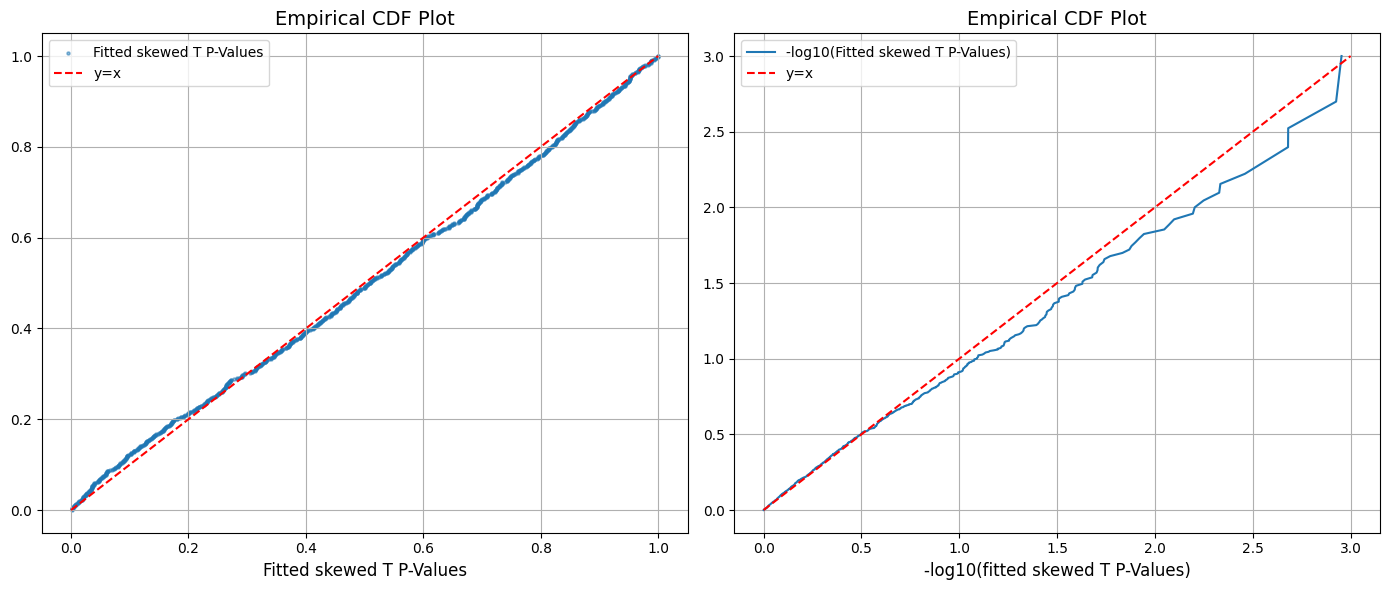

In [11]:
n_gene=1000
n_hets=10
n_depth=100
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
plot_empirical_CDF(qb_neg_p,dist="skewed T")

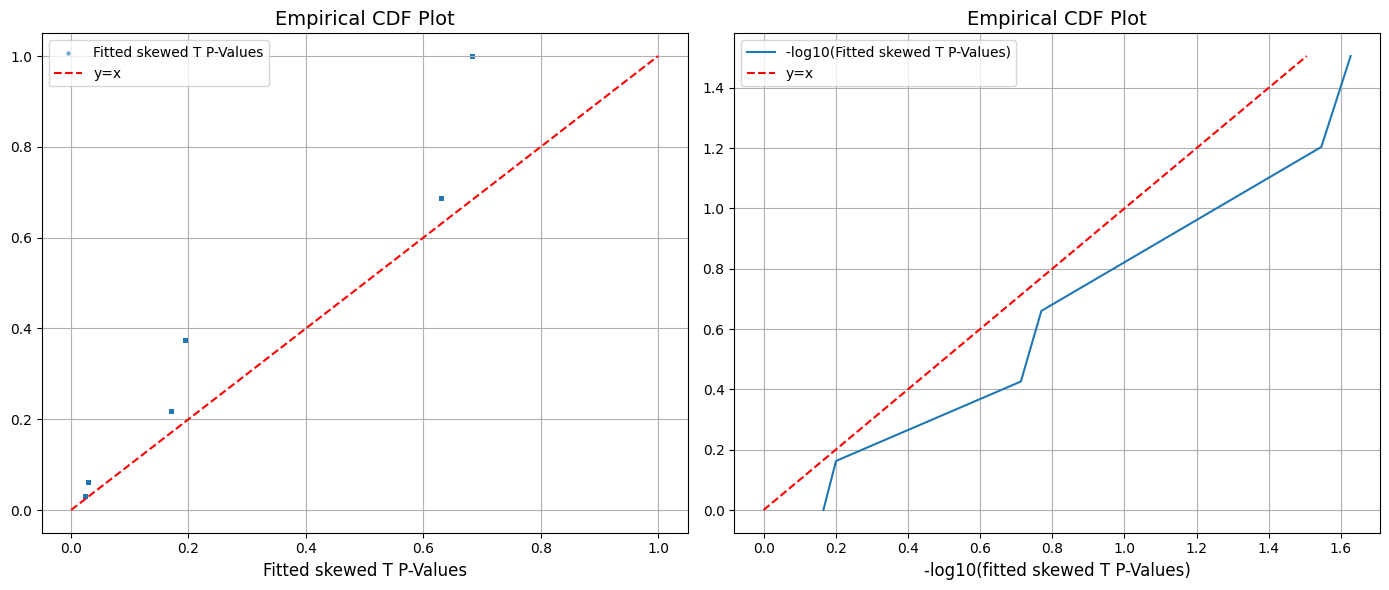

In [12]:
n_gene=19207904
n_hets=1
n_depth=5
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)

plot_empirical_CDF(qb_neg_p,dist="skewed T")

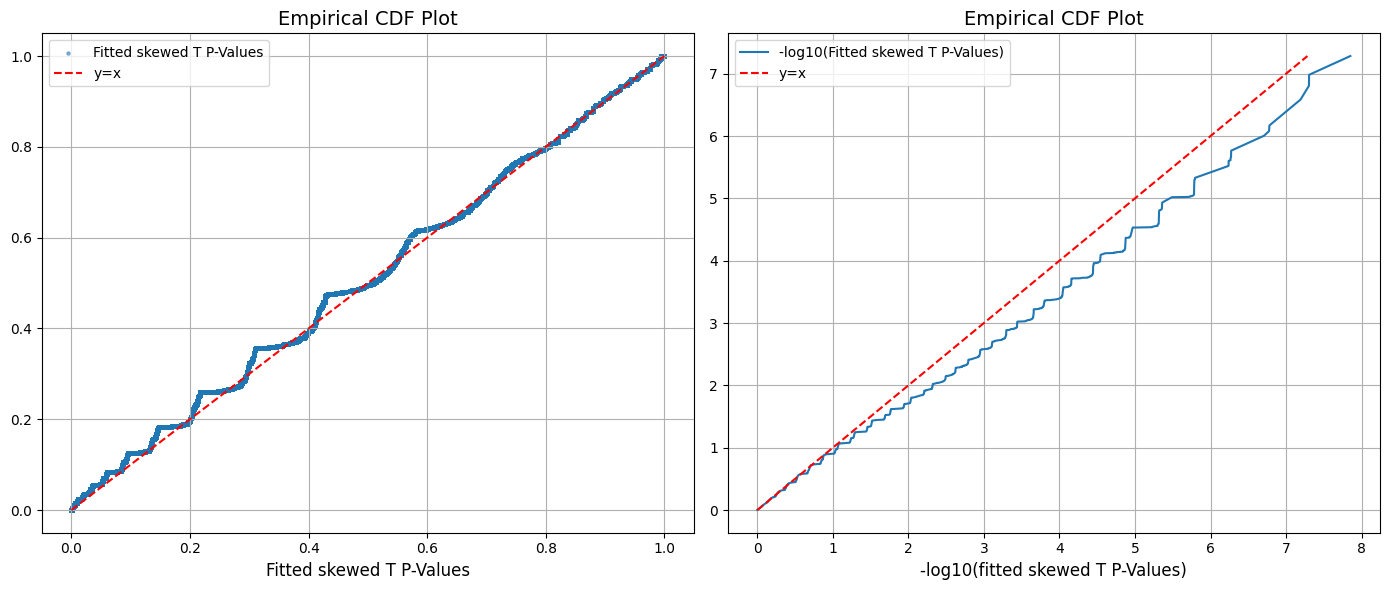

In [13]:
n_gene=19207904
n_hets=3
n_depth=30
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)

plot_empirical_CDF(qb_neg_p,dist="skewed T")

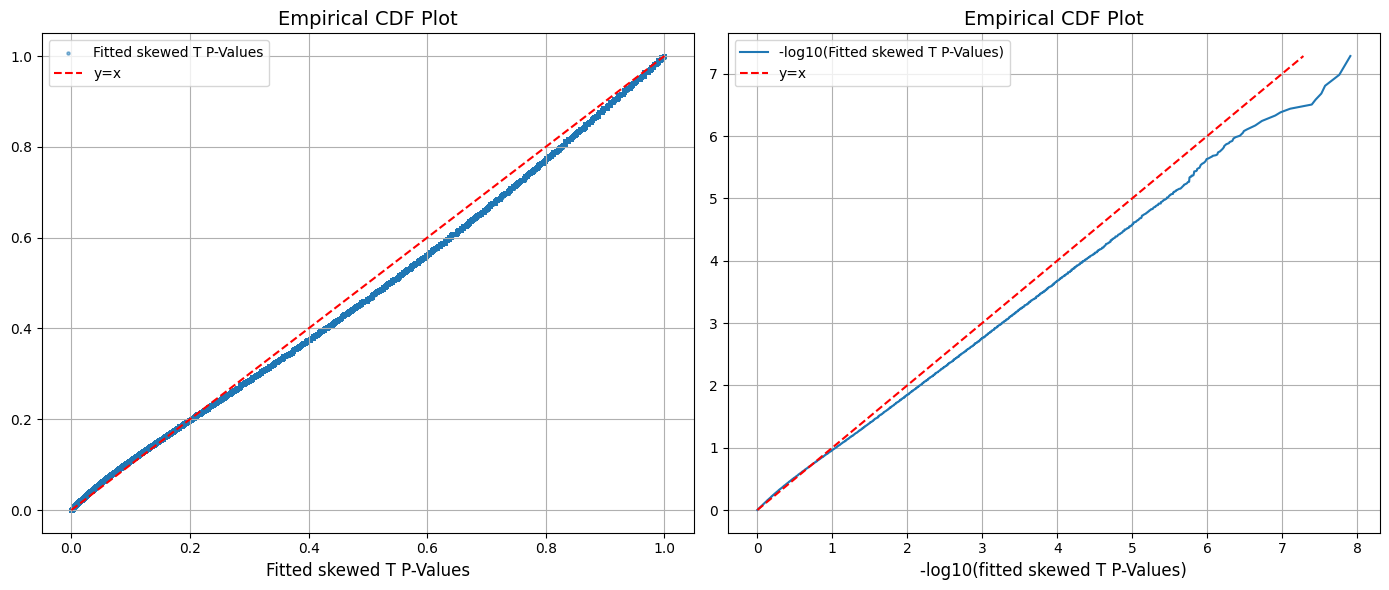

In [14]:
n_gene=19207904
n_hets=10
n_depth=100
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)

plot_empirical_CDF(qb_neg_p,dist="skewed T")

### mean

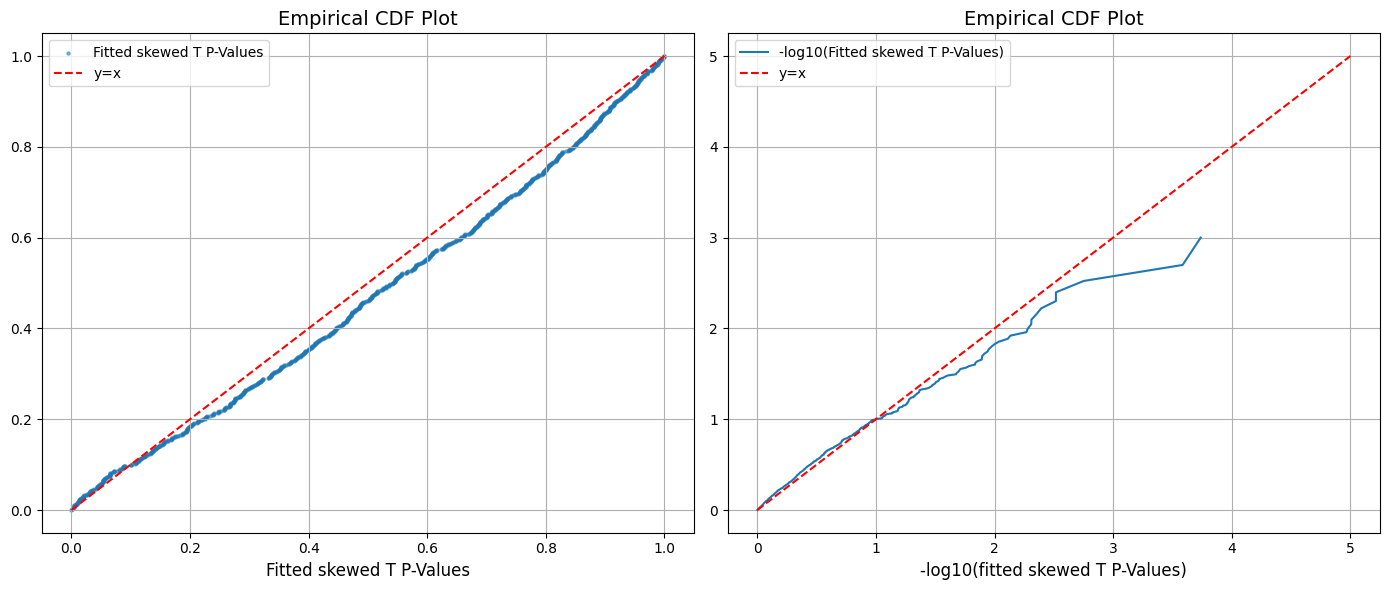

In [8]:
n_gene=1000
n_hets=10
n_depth=100
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
plot_empirical_CDF(qb_neg_p,dist="skewed T")


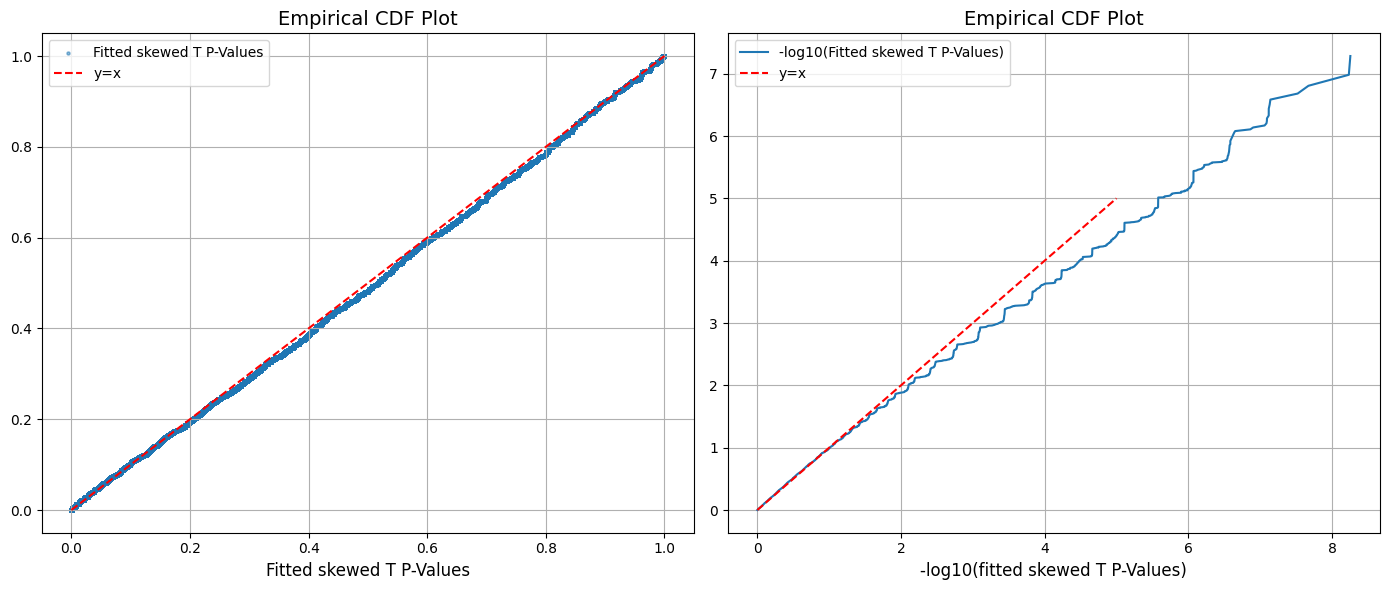

In [9]:
n_gene=19207904
n_hets=3
n_depth=30
alt=0.5
sigma=0.7
qb_pos_p, qb_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG = get_qb_ns_data(n_gene,n_hets,n_depth,alt,sigma=0.7)

plot_empirical_CDF(qb_neg_p,dist="skewed T")